In [1]:
import numpy as np
import pandas as pd
import scipy
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.preprocessing import normalize
from sklearn.decomposition import PCA

from sklearn.datasets.samples_generator import make_blobs
from sklearn.model_selection import train_test_split

from sklearn.cluster import KMeans
from sklearn.cluster import MeanShift, estimate_bandwidth
from sklearn.cluster import SpectralClustering
from sklearn.cluster import AffinityPropagation

from sklearn import metrics
from itertools import cycle

import matplotlib.cm as cm

from sklearn import metrics
from sklearn.metrics import pairwise_distances

In [2]:
df = pd.read_csv('boston2014.csv')
print(df.shape)
print(df.dtypes)
df.head()

(31984, 21)
10k           object
name          object
division       int64
25k           object
gender        object
age            int64
official     float64
bib           object
genderdiv      int64
ctz           object
35k           object
overall        int64
pace         float64
state         object
30k           object
5k            object
half          object
20k           object
country       object
city          object
40k           object
dtype: object


,10k,name,division,25k,gender,age,official,bib,genderdiv,ctz,...,overall,pace,state,30k,5k,half,20k,country,city,40k
0,17.37,"Yamamoto, Hiroyuki",8,47.67,M,47,85.25,W1,8,NaN,...,8,3.27,NaN,59.18,8.02,39.72,37.65,JPN,Fukuoka,80.43
1,32.58,"Jeptoo, Rita",1,82.43,F,33,138.95,F1,1,NaN,...,21,5.30,NaN,99.33,16.22,69.47,65.83,KEN,Eldoret,132.10
2,16.62,"Van Dyk, Ernst F.",1,45.80,M,41,80.60,W2,1,NaN,...,1,3.08,NaN,56.45,7.75,38.03,36.10,RSA,Paarl,76.10
3,32.57,"Dibaba, Mare",3,82.43,F,24,140.58,F2,3,NaN,...,27,5.37,NaN,99.33,16.20,69.47,65.83,ETH,Shoa,132.95
4,17.12,"Hokinoue, Kota",2,46.37,M,40,81.23,W3,2,NaN,...,2,3.10,NaN,57.03,8.02,38.60,36.58,JPN,Nogata Fukuoka,76.72


In [3]:
#convert splits from object to numerics
splits = ['10k', '25k', '35k', '30k', '5k', 'half', '20k', '40k']
df[splits] = df[splits].apply(pd.to_numeric, errors='coerce', axis=1)
df.dtypes

10k          float64
name          object
division       int64
25k          float64
gender        object
age            int64
official     float64
bib           object
genderdiv      int64
ctz           object
35k          float64
overall        int64
pace         float64
state         object
30k          float64
5k           float64
half         float64
20k          float64
country       object
city          object
40k          float64
dtype: object

In [4]:
#how many unique values are in our remaining features
categoricals = ['name', 'gender', 'bib', 'ctz', 'state', 'country', 'city']
df[categoricals].nunique()

#we won't cluster by name, and bins are non uniform so they aren't helpful
df = df.drop(['name', 'bib'], 1)

In [5]:
#convert gender into a binary format for analysis
df['gender'] = np.where(df['gender'] == 'M', 0, 1).astype('int64')

#lets drop location features for now, and look at them in a different cluster
gender_df = df.drop(['ctz', 'state', 'country', 'city'], 1)

In [6]:
from sklearn.preprocessing import normalize
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA

# Make sure the number of rows divides evenly into four samples.
rows = gender_df.shape[0] - gender_df.shape[0] % 4
gender_df = gender_df.iloc[:rows, :]
gender_df = gender_df.dropna()

#create feature set and target set
X = gender_df.drop('gender', 1)
y = gender_df.gender

In [7]:
print(len(X))
X.head()

31649


,10k,division,25k,age,official,genderdiv,35k,overall,pace,30k,5k,half,20k,40k
0,17.37,8,47.67,47,85.25,8,71.40,8,3.27,59.18,8.02,39.72,37.65,80.43
1,32.58,1,82.43,33,138.95,1,116.37,21,5.30,99.33,16.22,69.47,65.83,132.10
2,16.62,1,45.80,41,80.60,1,67.42,1,3.08,56.45,7.75,38.03,36.10,76.10
3,32.57,3,82.43,24,140.58,3,116.37,27,5.37,99.33,16.20,69.47,65.83,132.95
4,17.12,2,46.37,40,81.23,2,67.83,2,3.10,57.03,8.02,38.60,36.58,76.72


In [8]:
def set_X_groups(feature):
    #normalize X
    X = feature
    # Make sure the number of rows divides evenly into four samples.
    rows = X.shape[0] - X.shape[0] % 4
    X = X.iloc[:rows, :]
    X_norm = normalize(X)
    print(X.shape)
    
    #PCA with two components for plotting
    pca = PCA(n_components=2)
    X_pca = pca.fit_transform(X_norm)
    
    #train test split our group into equal quadrants
    X_half1, X_half2, X_pcahalf1, X_pcahalf2 = train_test_split(
        X_norm,
        X_pca,
        test_size=0.5,
        random_state=42)

    X1, X2, X_pca1, X_pca2 = train_test_split(
        X_half1,
        X_pcahalf1,
        test_size=0.5,
        random_state=42)
    
    X3, X4, X_pca3, X_pca4 = train_test_split(
        X_half2,
        X_pcahalf2,
        test_size=0.5,
        random_state=42)
    
    return X1, X_pca1, X2, X_pca2, X3, X_pca3, X4, X_pca4

In [9]:
X1, X_pca1, X2, X_pca2, X3, X_pca3, X4, X_pca4 = set_X_groups(gender_df)

(31648, 15)


In [10]:
#function that plots kmeans clustering and returns the optimal number of clusters
def evaluate_kmeans(X1, X_pca1, X2, X_pca2, X3, X_pca3, X4, X_pca4, clust_range):

    plot_clusters = pd.DataFrame()
    cluster_scores = pd.DataFrame(columns=['clusters','mean score','std'])
#compare our 4 even sections to each other and return a silhouette score
    for index, data in enumerate([
        (X1, X_pca1),
        (X2, X_pca2),
        (X3, X_pca3),
        (X4, X_pca4)]):

        plot_clusters['pca_f1' + '_sample' + str(index)] = data[1][:, 0]
        plot_clusters['pca_f2' + '_sample' + str(index)] = data[1][:, 1]

        for nclust in range(2, clust_range):
            km = KMeans(n_clusters=nclust, random_state=42)
            km.fit(data[0])
            labels = km.labels_
            cluster_pred = km.predict(data[0])
            plot_clusters['clust' + str(nclust) + '_sample' + str(index)] = cluster_pred
            plot_clusters['sil_score_' + 'clust'+ str(nclust) + '_sample' + str(index)] = \
                                metrics.silhouette_score(data[0], labels, metric='euclidean')
# plot the kmeans scores
    for nclust in range(2, clust_range):

        colors = cm.rainbow(np.linspace(0, 1, nclust))
        f, plotgrid = plt.subplots(2, 2)
        sil_scores = []

        for i in range(4):

            current_group = (f'clust{nclust}_sample{i}')

            x_plot = plot_clusters[f'pca_f1_sample{i}']
            y_plot = plot_clusters[f'pca_f2_sample{i}']

            c = plot_clusters[current_group]

            rows = int(np.floor(i / 2))
                # 0,0,1,1
            cols = i % 2
                # 0,1,0,1

            plotgrid[rows, cols].scatter(x_plot, y_plot, color = colors[c], alpha = 0.4)
            plotgrid[rows, cols].set_title(f'sample {i}')
            plotgrid[rows, cols].set_xlim([-.3, .3])
            plotgrid[rows, cols].set_ylim([-.3, .3])

            sil_score = plot_clusters['sil_score_' + str(current_group)].mean()
            sil_scores.append(sil_score)

#group the silhouette scores and print the means and standard deviations
        group_sil_scores_mean = np.mean(sil_scores)
        group_sil_scores_std = np.std(sil_scores)
        cluster_scores = cluster_scores.append({'clusters':int(nclust), 'mean score': group_sil_scores_mean, 'std': group_sil_scores_std}, ignore_index=True)
        print('scores:')
        print(cluster_scores)

        plt.suptitle(f'{nclust} Clusters', fontsize=20)
        plt.tight_layout()
        plt.show()
        print('\n')
    
    print('sorted cluster scores:')
    sorted_scores = cluster_scores.sort_values(by = ['mean score'], ascending = False)
    print(sorted_scores)

    best_cluster_num = int(sorted_scores['clusters'].iloc[0])
    print('best cluster num:')
    print(best_cluster_num)
    
    return best_cluster_num

scores:
   clusters  mean score       std
0       2.0    0.454315  0.007097


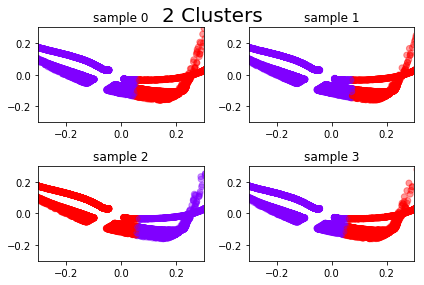



scores:
   clusters  mean score       std
0       2.0    0.454315  0.007097
1       3.0    0.477944  0.003580


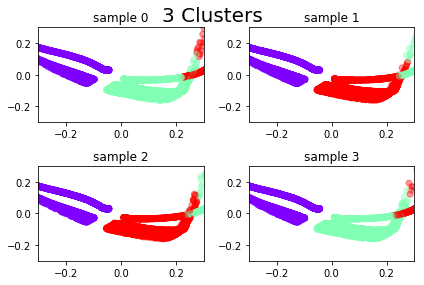



scores:
   clusters  mean score       std
0       2.0    0.454315  0.007097
1       3.0    0.477944  0.003580
2       4.0    0.495246  0.002009


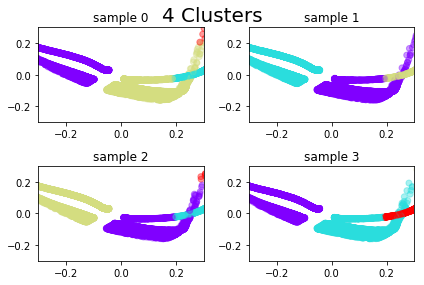



scores:
   clusters  mean score       std
0       2.0    0.454315  0.007097
1       3.0    0.477944  0.003580
2       4.0    0.495246  0.002009
3       5.0    0.437714  0.023892


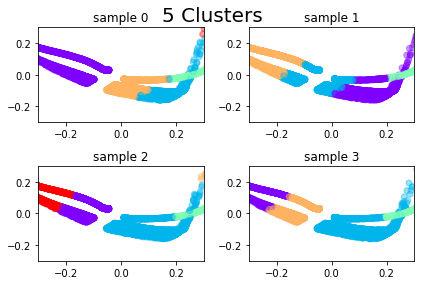



scores:
   clusters  mean score       std
0       2.0    0.454315  0.007097
1       3.0    0.477944  0.003580
2       4.0    0.495246  0.002009
3       5.0    0.437714  0.023892
4       6.0    0.450663  0.003008


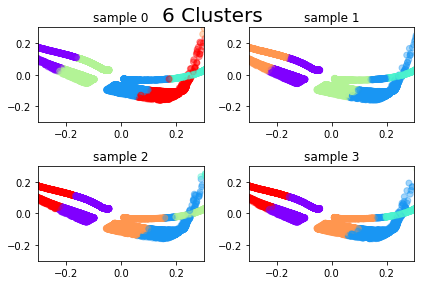



scores:
   clusters  mean score       std
0       2.0    0.454315  0.007097
1       3.0    0.477944  0.003580
2       4.0    0.495246  0.002009
3       5.0    0.437714  0.023892
4       6.0    0.450663  0.003008
5       7.0    0.527788  0.003477


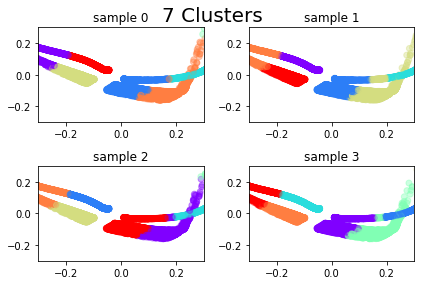



scores:
   clusters  mean score       std
0       2.0    0.454315  0.007097
1       3.0    0.477944  0.003580
2       4.0    0.495246  0.002009
3       5.0    0.437714  0.023892
4       6.0    0.450663  0.003008
5       7.0    0.527788  0.003477
6       8.0    0.533154  0.002232


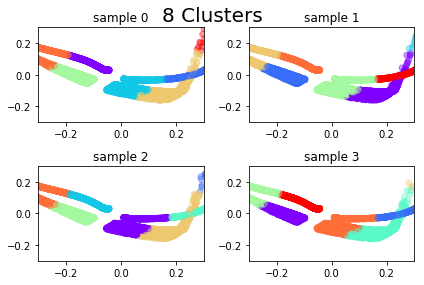



scores:
   clusters  mean score       std
0       2.0    0.454315  0.007097
1       3.0    0.477944  0.003580
2       4.0    0.495246  0.002009
3       5.0    0.437714  0.023892
4       6.0    0.450663  0.003008
5       7.0    0.527788  0.003477
6       8.0    0.533154  0.002232
7       9.0    0.558038  0.001363


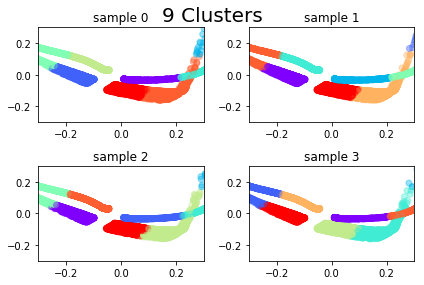



sorted cluster scores:
   clusters  mean score       std
7       9.0    0.558038  0.001363
6       8.0    0.533154  0.002232
5       7.0    0.527788  0.003477
2       4.0    0.495246  0.002009
1       3.0    0.477944  0.003580
0       2.0    0.454315  0.007097
4       6.0    0.450663  0.003008
3       5.0    0.437714  0.023892
best cluster num:
9


In [12]:
best_cluster_num = evaluate_kmeans(X1, X_pca1, X2, X_pca2, X3, X_pca3, X4, X_pca4, 10)